# Problem 2: Denoising AutoEncoders

In [24]:
# Cell 1 — imports & configuration
import os, glob, random, time, math, sys
from pathlib import Path
from typing import Optional, Tuple, List

import numpy as np
from PIL import Image, ImageFilter, ImageOps, ImageEnhance  # <- include ImageEnhance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.utils as vutils

# Prefer Apple Metal (M1/M2) → 'mps', else CUDA, else CPU
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

# Apple Metal tip (safe if unsupported; ignored elsewhere)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# optional: tiny CPU speed-up
torch.set_num_threads(max(1, os.cpu_count() // 2))

# imagecorruptions presence
_HAS_IMGCORR = False
try:
    from imagecorruptions import corrupt, get_corruption_names
    _HAS_IMGCORR = True
except Exception:
    _HAS_IMGCORR = False

print("Device:", DEVICE)
print("imagecorruptions installed:", _HAS_IMGCORR)


Device: mps
imagecorruptions installed: False


In [25]:
# Cell 2 — download VOC2012 and create 4:1 split
import kagglehub
import xml.etree.ElementTree as ET

path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")
print("Path to dataset files:", path)

def find_dir(root, name_lower):
    for dp, _, _ in os.walk(root):
        if os.path.basename(dp).lower() == name_lower.lower():
            return dp
    raise FileNotFoundError(f"Could not find '{name_lower}' under {root}")

ANN_DIR = find_dir(path, "Annotations")
IMG_DIR = find_dir(path, "JPEGImages")

def has_at_least_one_object(xml_path):
    root = ET.parse(xml_path).getroot()
    return len(root.findall("object")) > 0

def build_train_val_split_voc(root_path, train_ratio=0.8, seed=42, write_lists=True):
    ann_dir = find_dir(root_path, "Annotations")
    img_dir = find_dir(root_path, "JPEGImages")

    pairs = []
    for xml in glob.glob(os.path.join(ann_dir, "*.xml")):
        stem = os.path.splitext(os.path.basename(xml))[0]
        img = os.path.join(img_dir, stem + ".jpg")
        if os.path.exists(img) and has_at_least_one_object(xml):
            pairs.append((img, xml))

    rng = random.Random(seed)
    rng.shuffle(pairs)
    n_train = int(len(pairs) * train_ratio)
    train_pairs, val_pairs = pairs[:n_train], pairs[n_train:]

    if write_lists:
        split_dir = os.path.join(root_path, "ImageSets", "Main")
        os.makedirs(split_dir, exist_ok=True)
        def write_list(fname, subset):
            with open(os.path.join(split_dir, fname), "w") as f:
                for img_path, _ in subset:
                    f.write(os.path.splitext(os.path.basename(img_path))[0] + "\n")
        write_list("train.txt", train_pairs)
        write_list("val.txt",   val_pairs)

    print(f"Eligible samples: {len(pairs)} | Train: {len(train_pairs)} | Val: {len(val_pairs)}")
    return train_pairs, val_pairs

train_pairs, val_pairs = build_train_val_split_voc(path, train_ratio=0.8, seed=SEED, write_lists=True)


Path to dataset files: /Users/user/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1
Eligible samples: 17125 | Train: 13700 | Val: 3425


In [ ]:
# ---- drop-in replacement for make_loaders_from_pairs ----
import multiprocessing as mp
from torch.utils.data import DataLoader

def make_loaders_from_pairs(train_pairs, val_pairs,
                            image_size=128, batch_size=32,
                            severity=3, corruption_name=None,
                            num_workers=4,
                            max_train=None, max_val=None,
                            seed=42):
    """
    Uses multiprocessing_context='fork' so notebook-defined classes work with workers on macOS.
    """
    rng = random.Random(seed)
    tr_imgs = [p for p, _ in train_pairs]
    va_imgs = [p for p, _ in val_pairs]

    if max_train is not None and len(tr_imgs) > max_train:
        rng.shuffle(tr_imgs); tr_imgs = tr_imgs[:max_train]
    if max_val is not None and len(va_imgs) > max_val:
        rng.shuffle(va_imgs); va_imgs = va_imgs[:max_val]

    # IMPORTANT: use "fork" context to avoid spawn-pickle import issues
    mp_ctx = mp.get_context("fork")

    pin_mem  = (DEVICE.type == "cuda")
    prefetch = 2 if num_workers > 0 else None

    trn = DataLoader(
        PairedCorruptionListDataset(tr_imgs, image_size, severity, corruption_name),
        batch_size=batch_size, shuffle=True,
        num_workers=num_workers, prefetch_factor=prefetch,
        persistent_workers=(num_workers > 0), pin_memory=pin_mem,
        multiprocessing_context=mp_ctx
    )
    val = DataLoader(
        PairedCorruptionListDataset(va_imgs, image_size, severity, corruption_name),
        batch_size=batch_size, shuffle=False,
        num_workers=num_workers, prefetch_factor=prefetch,
        persistent_workers=(num_workers > 0), pin_memory=pin_mem,
        multiprocessing_context=mp_ctx
    )
    return trn, val


Data module ready: /Users/user/Documents/CS675D/Assignments/HW3/dae_data.py


In [27]:
# Cell 4 — model
class DenoiseAE(nn.Module):
    def __init__(self, ch=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(ch, ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # 128→64
            nn.Conv2d(ch, ch*2, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(ch*2, ch*2, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # 64→32
            nn.Conv2d(ch*2, ch*4, 3, padding=1), nn.ReLU(inplace=True),
        )
        self.dec = nn.Sequential(
            nn.Conv2d(ch*4, ch*2, 3, padding=1), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="nearest"),  # 32→64
            nn.Conv2d(ch*2, ch*2, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(ch*2, ch, 3, padding=1),   nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="nearest"),  # 64→128
            nn.Conv2d(ch, ch, 3, padding=1),     nn.ReLU(inplace=True),
            nn.Conv2d(ch, 3, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.dec(self.enc(x))


In [33]:
# Cell 5 — training utils
@torch.no_grad()
def psnr(pred, target, eps=1e-8):
    mse = F.mse_loss(pred, target, reduction='mean').item()
    return 20 * math.log10(1.0 / math.sqrt(mse + eps))

@torch.no_grad()
def save_triplets(model, val_loader, save_path, max_rows=6, device=None):
    device = device or next(model.parameters()).device
    x_cor, x_clean = next(iter(val_loader))
    x_cor, x_clean = x_cor.to(device), x_clean.to(device)
    y_hat = model(x_cor)

    rows = min(max_rows, x_cor.size(0))
    tiles = []
    for i in range(rows):
        tiles.extend([x_cor[i].cpu(), y_hat[i].cpu(), x_clean[i].cpu()])
    grid = vutils.make_grid(tiles, nrow=3, padding=2)
    Path(os.path.dirname(save_path)).mkdir(parents=True, exist_ok=True)
    vutils.save_image(grid, save_path)
    print(f"Saved triplets → {save_path}")

def make_loaders_from_pairs(train_pairs, val_pairs,
                            image_size=128, batch_size=32,
                            severity=3, corruption_name=None,
                            num_workers=4,                 # works now (module importable)
                            max_train=None, max_val=None,  # FAST caps
                            seed=42):
    rng = random.Random(seed)
    tr_imgs = [p for p, _ in train_pairs]
    va_imgs = [p for p, _ in val_pairs]
    if max_train is not None and len(tr_imgs) > max_train:
        rng.shuffle(tr_imgs); tr_imgs = tr_imgs[:max_train]
    if max_val is not None and len(va_imgs) > max_val:
        rng.shuffle(va_imgs); va_imgs = va_imgs[:max_val]

    pin_mem = (DEVICE.type == "cuda")  # pin only for CUDA
    prefetch = 2 if num_workers > 0 else None

    trn = DataLoader(
        dae_data.PairedCorruptionListDataset(tr_imgs, image_size, severity, corruption_name),
        batch_size=batch_size, shuffle=True,
        num_workers=num_workers, prefetch_factor=prefetch, persistent_workers=(num_workers>0),
        pin_memory=pin_mem
    )
    val = DataLoader(
        dae_data.PairedCorruptionListDataset(va_imgs, image_size, severity, corruption_name),
        batch_size=batch_size, shuffle=False,
        num_workers=num_workers, prefetch_factor=prefetch, persistent_workers=(num_workers>0),
        pin_memory=pin_mem
    )
    return trn, val

def train_model_from_pairs(train_pairs, val_pairs,
                           out_dir="outputs_ae",
                           image_size=128,
                           epochs=5,
                           batch_size=32,
                           lr=1e-3,
                           severity=3,
                           corruption_name=None,
                           num_workers=4,
                           max_train=None, max_val=None):
    trn, val = make_loaders_from_pairs(train_pairs, val_pairs,
                                       image_size, batch_size,
                                       severity, corruption_name,
                                       num_workers, max_train, max_val)
    model = DenoiseAE().to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    best  = float("inf")
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    for ep in range(1, epochs+1):
        model.train(); t0=time.time(); trn_loss=0.0
        for x_cor, x_clean in trn:
            x_cor, x_clean = x_cor.to(DEVICE), x_clean.to(DEVICE)
            y = model(x_cor); loss = F.mse_loss(y, x_clean)
            opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
            trn_loss += loss.item() * x_cor.size(0)
        trn_loss /= len(trn.dataset)

        model.eval(); val_loss=0.0; val_psnr=0.0
        with torch.no_grad():
            for x_cor, x_clean in val:
                x_cor, x_clean = x_cor.to(DEVICE), x_clean.to(DEVICE)
                y = model(x_cor)
                val_loss += F.mse_loss(y, x_clean, reduction='sum').item()
                val_psnr += psnr(y, x_clean) * x_cor.size(0)
        val_loss /= len(val.dataset)
        val_psnr /= len(val.dataset)

        dt = time.time() - t0
        print(f"Epoch {ep:02d} | train_mse={trn_loss:.5f} | val_mse={val_loss:.5f} | val_psnr={val_psnr:.2f} dB | {dt:.1f}s")
        save_triplets(model, val, os.path.join(out_dir, f"triplets_ep{ep:02d}.png"), device=DEVICE)
        if val_loss < best:
            best = val_loss
            torch.save(model.state_dict(), os.path.join(out_dir, "best_ae.pt"))
    return model


In [34]:
# Cell 6 — run training
CORRUPTION_NAME = None   # or e.g. 'jpeg_compression', 'gaussian_noise'
SEVERITY        = 3
IMAGE_SIZE      = 96     # smaller → faster on CPU/MPS
BATCH_SIZE      = 64     # drop to 32 if memory is tight
EPOCHS          = 3
LR              = 1e-3

NUM_WORKERS     = 4      # if you still see worker issues, set to 0
MAX_TRAIN       = 4000   # cap for speed (set None for full dataset)
MAX_VAL         = 800

print("Device:", DEVICE, "| workers:", NUM_WORKERS, "| fast caps:", MAX_TRAIN, MAX_VAL)
model = train_model_from_pairs(
    train_pairs, val_pairs,
    out_dir="outputs_ae",
    image_size=IMAGE_SIZE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    severity=SEVERITY,
    corruption_name=CORRUPTION_NAME,
    num_workers=NUM_WORKERS,
    max_train=MAX_TRAIN, max_val=MAX_VAL
)


Device: mps | workers: 4 | fast caps: 4000 800
Epoch 01 | train_mse=0.03472 | val_mse=551.94762 | val_psnr=17.01 dB | 31.4s
Saved triplets → outputs_ae/triplets_ep01.png
Epoch 02 | train_mse=0.01804 | val_mse=461.46793 | val_psnr=17.80 dB | 17.0s
Saved triplets → outputs_ae/triplets_ep02.png
Epoch 03 | train_mse=0.01374 | val_mse=354.60433 | val_psnr=18.93 dB | 17.2s
Saved triplets → outputs_ae/triplets_ep03.png


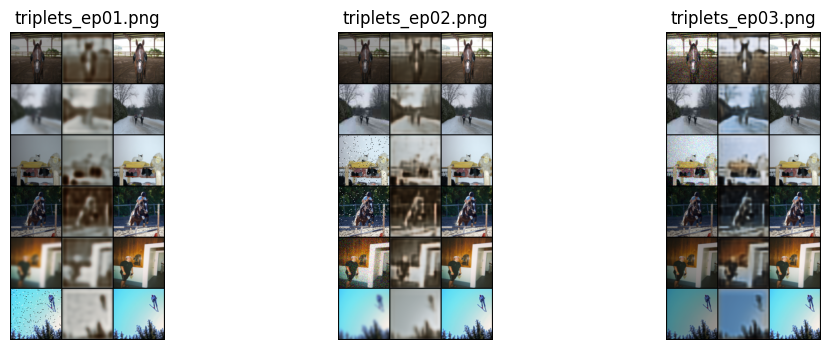

In [35]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

triplets = sorted(glob.glob("outputs_ae/triplets_ep*.png"))
fig, axes = plt.subplots(1, len(triplets), figsize=(4*len(triplets), 4))
for ax, tpath in zip(axes, triplets):
    ax.imshow(Image.open(tpath))
    ax.set_title(os.path.basename(tpath))
    ax.axis("off")
plt.show()


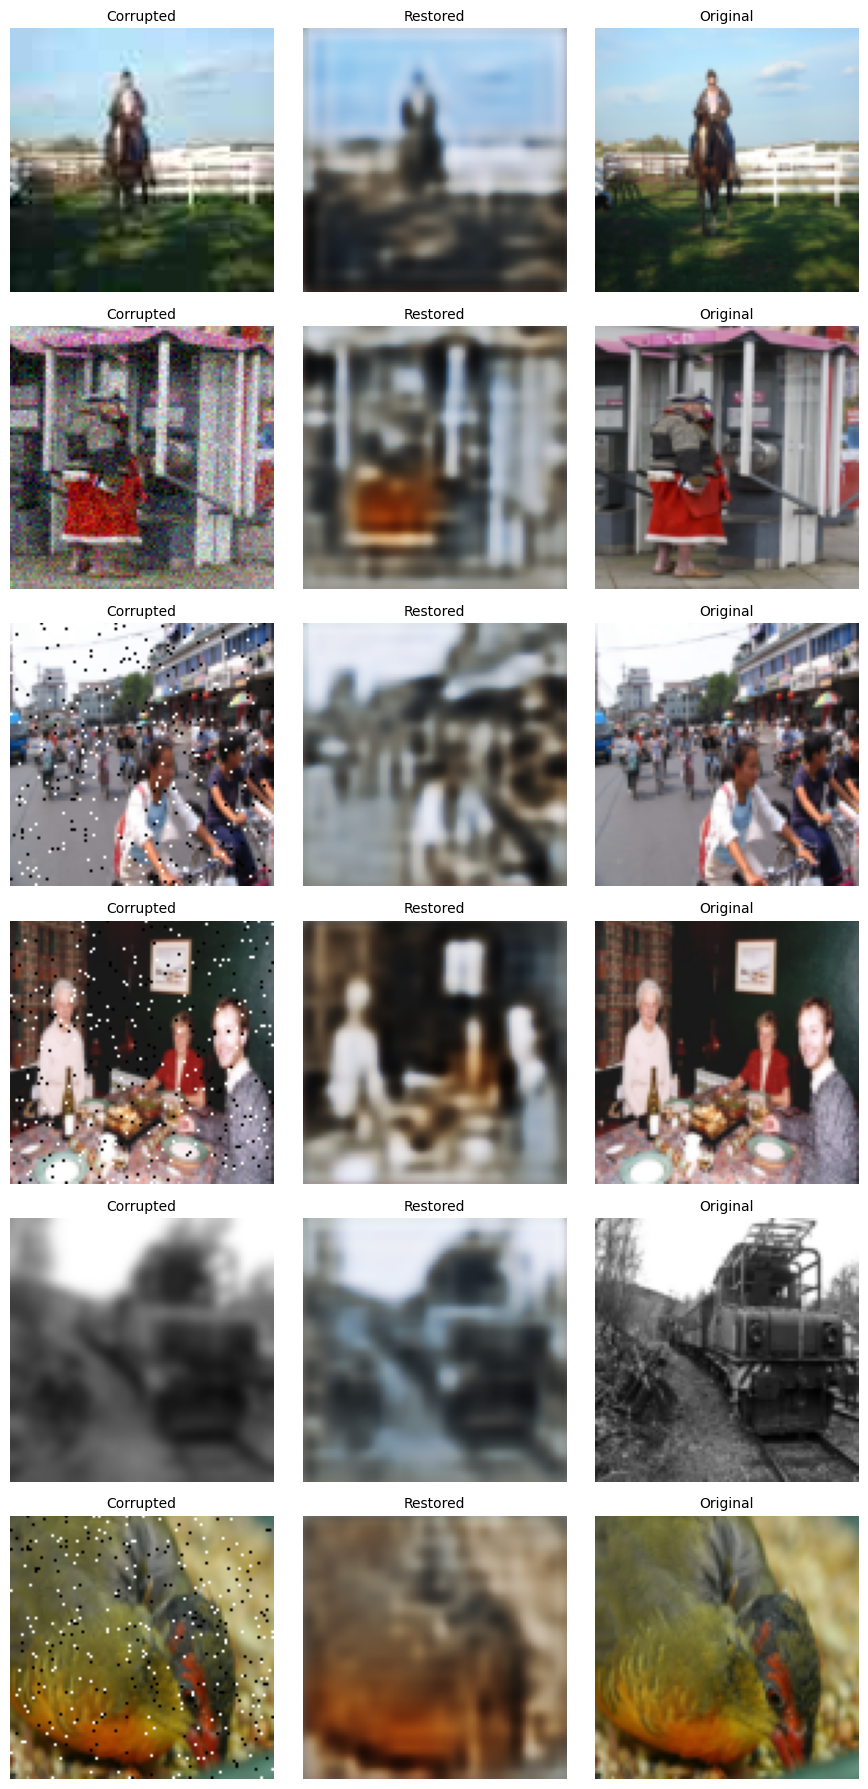

Saved triplets → outputs_ae/showcase_val.png


In [36]:
# Inline visualization helpers
import matplotlib.pyplot as plt

def _to_numpy(img_t):
    """CHW [0,1] -> HWC uint8 for matplotlib."""
    x = img_t.detach().cpu().clamp(0,1).permute(1,2,0).numpy()
    return (x * 255).astype("uint8")

@torch.no_grad()
def show_and_save_triplets(model, val_loader, save_path=None, rows=6, device=None):
    """
    Shows a grid in-notebook AND optionally saves a PNG.
    Columns: [Corrupted | Restored | Original]
    """
    device = device or next(model.parameters()).device
    model.eval()
    x_cor, x_clean = next(iter(val_loader))
    x_cor, x_clean = x_cor.to(device), x_clean.to(device)
    y_hat = model(x_cor)

    n = min(rows, x_cor.size(0))
    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(9, 3*n))
    if n == 1:
        axes = np.array([axes])  # normalize shape

    for i in range(n):
        trip = [x_cor[i], y_hat[i], x_clean[i]]
        titles = ["Corrupted", "Restored", "Original"]
        for j in range(3):
            ax = axes[i, j]
            ax.imshow(_to_numpy(trip[j]))
            ax.set_title(titles[j], fontsize=10)
            ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Optional save to disk (same image as shown)
    if save_path is not None:
        # Reuse existing save_triplets to write a PNG grid
        save_triplets(model, val_loader, save_path, max_rows=rows, device=device)


# Build a validation loader (same settings you trained with)
val_loader_only = make_loaders_from_pairs(
    train_pairs, val_pairs,
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    severity=SEVERITY, corruption_name=CORRUPTION_NAME,
    num_workers=NUM_WORKERS, max_train=None, max_val=MAX_VAL
)[1]

# Show in notebook AND save to file
show_and_save_triplets(
    model, val_loader_only,
    save_path="outputs_ae/showcase_val.png",  # or None to skip saving
    rows=6, device=DEVICE
)
